# Machine Learning - Decision Trees and Ensemble Learning

## Decision Trees:
Decision trees are a versatile tool in machine learning for classification and regression tasks. They mimic human decision-making by creating a flowchart-like structure to make predictions based on input features.

## Goal

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

### Dataset

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

### Prepare the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

**Preparation:**

- Fill missing values with zeros.
- Apply the log tranform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [2]:
# load the data from housing.csv into a Pandas dataframe
df = pd.read_csv('housing.csv')

# keep only records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# fill in the missing values with zeros
df = df.fillna(0)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [3]:
# apply log transform to median_house_value
features = 'median_house_value'
df[features] = np.log1p(df[features])

# split the data in train/val/test sets, with 60%/20%/20% distribution with seed 1
# .2 splits the data into 80% train and 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#.25 splits the 80% train into 60% train and 20% val
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset the indexes of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# separate the target variable from the train/val/test sets
y_train = df_train[features].values
y_val = df_val[features].values
y_test = df_test[features].values

# Separate features and target
train_features = df_train.drop(features, axis=1)
val_features = df_val.drop(features, axis=1)
test_features = df_test.drop(features, axis=1)

In [4]:
# Convert dataframes to dictionaries
train_dict = train_features.to_dict(orient='records')
val_dict = val_features.to_dict(orient='records')
test_dict = test_features.to_dict(orient='records')

# Initialize DictVectorizer
dv = DictVectorizer(sparse=True)

# Transform features using DictVectorizer
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# Print the shapes of transformed data
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (9411, 10)
X_val shape: (3138, 10)
X_test shape: (3138, 10)


## Question 1 - Which feature is used for splitting the data?
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1

- ocean_proximity
- total_rooms
- latitude
- population

In [5]:
# Train a decision tree regressor with max_depth=1
model = DecisionTreeRegressor(max_depth=1, random_state=1)
model.fit(X_train, y_train)

# Get the feature used for splitting
splitting_feature = train_features.columns[model.tree_.feature[0]]
print('The feature used for splitting:', splitting_feature)

The feature used for splitting: population


In [6]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

print (f' pred {y_val_pred[:5]} \n target {y_val[:5]}')

rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'RMSE on validation: {rmse}')


 pred [12.23651651 12.09841222 11.58549383 12.08792117 12.31897298] 
 target [12.09122841 12.14153946 11.47834437 11.94015859 12.36734505]
RMSE on validation: 0.24501215124257716


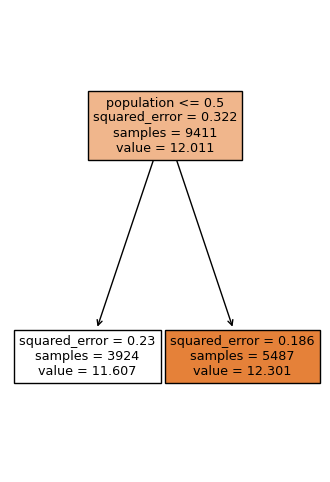

In [7]:
import matplotlib.pyplot as plt
from sklearn import tree
# Plot the decision tree
fig, ax = plt.subplots(figsize=(4, 6))
tree.plot_tree(model, feature_names=df_train.columns, filled=True, ax=ax)
plt.show()


## Question 3 - After which value of n_estimators does RMSE stop improving?
Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 25
- 50
- 160

In [8]:
# Experiment with estimators
estimators = list(range(10, 200, 10))
rmse_values = []

for n in estimators:
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    rmse_values.append(rmse)
    print(f'n:{n},RMSE={rmse}')


n:10,RMSE=0.24501215124257716
n:20,RMSE=0.2390976328831568
n:30,RMSE=0.23694588128593363
n:40,RMSE=0.23524661060552135
n:50,RMSE=0.23528935062232706
n:60,RMSE=0.23499205951298469
n:70,RMSE=0.23487031480731344
n:80,RMSE=0.23497451072905481
n:90,RMSE=0.23486712375821456
n:100,RMSE=0.23457854834306097
n:110,RMSE=0.23462470952704864
n:120,RMSE=0.23441395173165275
n:130,RMSE=0.2343082720044943
n:140,RMSE=0.2339938362049157
n:150,RMSE=0.23386041163827959
n:160,RMSE=0.23381114260119626
n:170,RMSE=0.23377406449040083
n:180,RMSE=0.23387911064045555
n:190,RMSE=0.23410707577682208


Best estimators: 170, Best RMSE: 0.23377406449040083


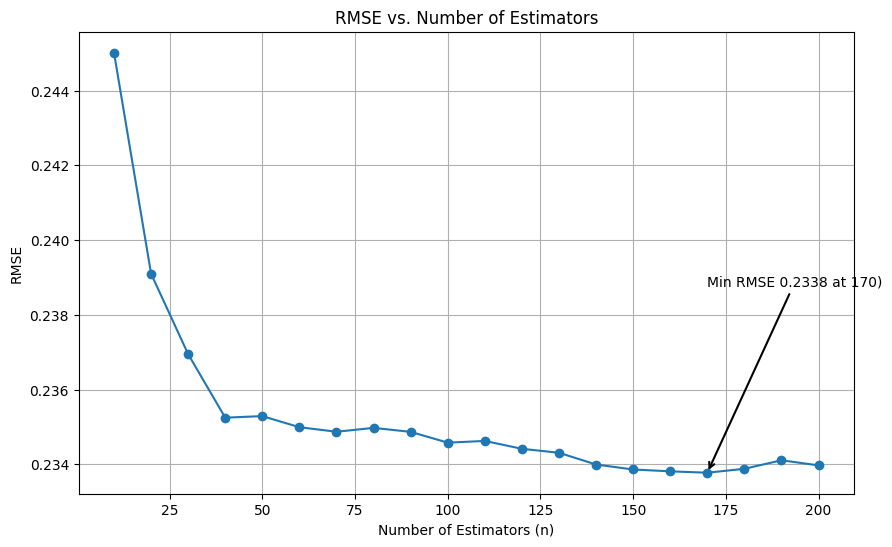

In [48]:
# Find the point where RMSE stops improving
min_rmse = min(rmse_values)
best_estimator = estimators[rmse_values.index(min_rmse)]
print(f'Best estimators: {best_estimator}, Best RMSE: {min_rmse}')

# Plot the RMSE values against the estimators values
plt.figure(figsize=(8, 5))
plt.plot(estimators, rmse_values, marker='o')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Estimators')
plt.grid(True)

# Add label for the minimum RMSE point
plt.annotate(f'Min RMSE {min_rmse:.4f} at {best_estimator})', xy=(best_estimator, min_rmse), 
             xytext=(best_estimator, min_rmse + 0.005),
             arrowprops=dict(arrowstyle='->', lw=1.5))

plt.show()

## Question 4 - What's the best max_depth:

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth:

- 10
- 15
- 20
- 25

In [11]:
# Experiment with mac depth and estimators
max_depths = [10, 15, 20, 25]
estimators = list(range(10, 200, 10))
max_d_results = {}

for d in max_depths:
    rmse_d_values = []
    for n in estimators:
        rf_model = RandomForestRegressor(max_depth=d,n_estimators=n, random_state=1, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        y_val_pred = rf_model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        rmse_d_values.append(rmse) 
    
    # get the best rmses for each max_depth  and the corresponding estimator    
    # key: max_depth, value: (best_rmse, best_estimator)
    # e.g. {10: (0.165, 180), 15: (0.163, 180), ...}
    # this will be used to plot the RMSE values  against the number of estimators for each max_depth            
    min_rmse = min(rmse_d_values)
    best_estimator = estimators[rmse_d_values.index(min_rmse)]
    max_d_results[d] = (min_rmse, best_estimator)    
    

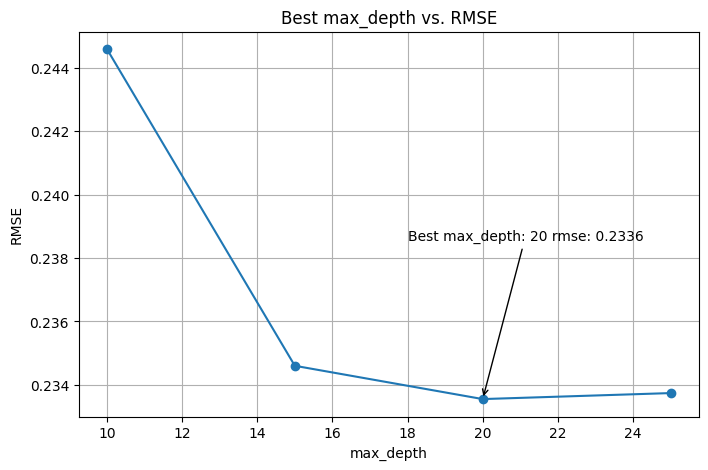

Best max_depth: 20, Best RMSE: 0.23355026965658257


In [20]:
# plot the max_depth (x axis) vs. RMSE values (y axis) 
# for each max_depth, plot the RMSE values against the number of estimators
max_depth_values = list(max_d_results.keys())
rmse_d_values = [x[0] for x in max_d_results.values()]
plt.figure(figsize=(8, 5))
plt.plot(max_depth_values, rmse_d_values, marker='o', linestyle='-')
plt.title('Best max_depth vs. RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.grid(True)

min_rmse = min(rmse_d_values)
best_max_depth = max_depth_values[rmse_d_values.index(min_rmse)]

# Add a label for the best max_depth
plt.annotate(f'Best max_depth: {best_max_depth} rmse: {min_rmse:.4f}', 
             xy=(best_max_depth, min_rmse), 
             xytext=(best_max_depth -2 , min_rmse + 0.005),
             arrowprops=dict(arrowstyle='->'))

plt.show()
print(f'Best max_depth: {best_max_depth}, Best RMSE: {min_rmse}')

## Question 5 - What's the most important feature (among these 4)?

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
  - n_estimators=10,
  - max_depth=20,
  - random_state=1,
  - n_jobs=-1 (optional)
- Get the feature importance information from this model
- 
What's the most important feature (among these 4)?

- total_rooms
- median_income
- total_bedrooms
- longitude

In [26]:
# get the most important features from the random forest model
rf_model = RandomForestRegressor(max_depth=20,n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)
feature_importance = rf_model.feature_importances_

# get the max feature index
max_feature_index = np.argmax(feature_importance)

# Get the feature name corresponding to the index
most_important_feature = dv.get_feature_names_out()[max_feature_index]

# get the max feature importance value
most_important_feature_value = feature_importance[max_feature_index]

print(f'Most important feature - {most_important_feature}: {most_important_feature_value:.4f} ')


Most important feature - median_income: 0.3354 


## Question 6 - Which eta leads to the best RMSE score on the validation dataset?

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value
- 

In [28]:
import xgboost as xgb

# Create DMatrix for train and validation datasets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define the parameters for the XGBoost model
xgb_params = {
    'eta': 0.3,  # Starting with an initial eta value
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Create a watchlist to keep track of the validation dataset
watchlist = [(dval, 'eval'), (dtrain, 'train')]

# Train the XGBoost model for 100 rounds with the initial `eta` value of 0.3:
num_round = 100

# evaluate with different etas
eta_list = [0.3, 0.1]

In [57]:
# train the model with a different eta   
rmse_eta_results = {}
xgb_model = None
for eta in eta_list:
    xgb_params['eta'] = eta  # Change the eta value
    model = xgb.train(xgb_params, dtrain, num_round, evals=watchlist, early_stopping_rounds=10)
    
    # save a model to run a sample prediction later
    if xgb_model is None:
        xgb_model = model
        
    y_val_pred = model.predict(dval)
    rmse_eta = mean_squared_error(y_val, y_val_pred, squared=False)
    rmse_eta_results[eta] = rmse_eta    

[0]	eval-rmse:0.44250	train-rmse:0.44350
[1]	eval-rmse:0.36916	train-rmse:0.36599
[2]	eval-rmse:0.32382	train-rmse:0.31556
[3]	eval-rmse:0.29965	train-rmse:0.28541
[4]	eval-rmse:0.28417	train-rmse:0.26573
[5]	eval-rmse:0.27463	train-rmse:0.25338
[6]	eval-rmse:0.26770	train-rmse:0.24157
[7]	eval-rmse:0.26423	train-rmse:0.23486
[8]	eval-rmse:0.25820	train-rmse:0.22668
[9]	eval-rmse:0.25444	train-rmse:0.21995
[10]	eval-rmse:0.25179	train-rmse:0.21444
[11]	eval-rmse:0.25054	train-rmse:0.21155
[12]	eval-rmse:0.24791	train-rmse:0.20729
[13]	eval-rmse:0.24628	train-rmse:0.20317
[14]	eval-rmse:0.24630	train-rmse:0.20135
[15]	eval-rmse:0.24522	train-rmse:0.19858
[16]	eval-rmse:0.24445	train-rmse:0.19580
[17]	eval-rmse:0.24395	train-rmse:0.19333
[18]	eval-rmse:0.24284	train-rmse:0.19107
[19]	eval-rmse:0.24127	train-rmse:0.18735
[20]	eval-rmse:0.23978	train-rmse:0.18524
[21]	eval-rmse:0.23963	train-rmse:0.18332
[22]	eval-rmse:0.23892	train-rmse:0.18189
[23]	eval-rmse:0.23847	train-rmse:0.18006
[2

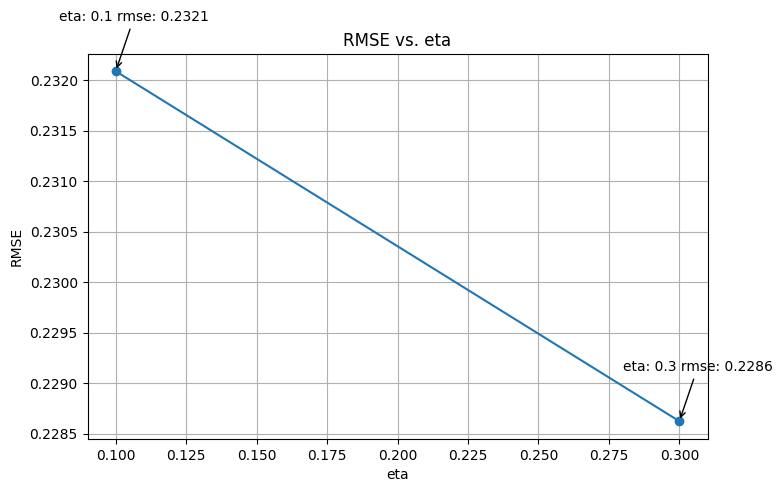

In [54]:
# plot the eta values with the corresponding RMSE values
eta_values = list(rmse_eta_results.keys())
rmse_eta_values = [x for x in rmse_eta_results.values()]
plt.figure(figsize=(8, 5))
plt.plot(eta_values, rmse_eta_values, marker='o', linestyle='-')
plt.title('RMSE vs. eta')
plt.xlabel('eta')
plt.ylabel('RMSE')
plt.grid(True)

# Add a label for the eta rmse point
for eta in eta_values:
    plt.annotate(f'eta: {eta} rmse: {rmse_eta_results[eta]:.4f}', 
             xy=(eta, rmse_eta_results[eta]), 
             xytext=(eta - 0.02 , rmse_eta_results[eta] + 0.0005),
             arrowprops=dict(arrowstyle='->'))

plt.show()


## Using the models example

In [59]:
# Prepare the data

# sample input record
sample_input = {
    'longitude': -118.21,
    'latitude': 34.05,
    'housing_median_age': 25,
    'total_rooms': 4300,
    'total_bedrooms': np.nan,  # Missing value
    'population': 1230,
    'households': 400,
    'median_income': 4.8,
    'ocean_proximity': 'INLAND'
}

# Create a DataFrame from the sample input
sample_df = pd.DataFrame([sample_input])

# Fill missing values (NaN) with zeros or other appropriate strategies
sample_df.fillna(0, inplace=True)

# Apply log(1+x) transformation to the target variable 
# sample_df['median_house_value'] = np.log1p(sample_df['median_house_value'])

# Convert the DataFrame to a dictionary for DictVectorizer
sample_dict = sample_df.to_dict(orient='records')

# Use DictVectorizer (dv) to transform the data into the required format
sample_encoded = dv.transform(sample_dict)

# Make predictions using the Random Forest and XGBoost models
rf_predictions = rf_model.predict(sample_encoded)
sample_encoded_matrix = xgb.DMatrix(sample_encoded)
xgb_predictions = xgb_model.predict(sample_encoded_matrix)

# Apply inverse log transformation to get the final predicted house prices
rf_predicted_price = np.expm1(rf_predictions)
xgb_predicted_price = np.expm1(xgb_predictions)

print("Random Forest Predicted Price:", rf_predicted_price[0])
print("XGBoost Predicted Price:", xgb_predicted_price[0])


Random Forest Predicted Price: 245201.18878716478
XGBoost Predicted Price: 254581.94
